# Teacher Student Network Research

##### Teacher Student Network Research
Framework adapted from Official Pytorch Knowledge Distillation Tutorial

Author:
Asad Amiruddin,
Harrison Maximillian Rush,
Huy N Ho

### Import library, datasets, loaders

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')


%load_ext autoreload
%autoreload 2

if IN_COLAB:
    !git clone https://github.com/pytorch/captum
    %cd captum
    !git checkout "v0.2.0"
    !pip3 install -e .
    import sys
    sys.path.append('/content/captum')
    %cd ..

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from time import time
from torchvision import models
from torchvision.transforms.functional import InterpolationMode

import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, DeepLift, LayerGradCam, LayerAttribution
from matplotlib import pyplot as plt
from captum.attr import visualization as viz
from torchvision import models


# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_nonorm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataset_nonorm = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_nonorm)

# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader_nonorm = torch.utils.data.DataLoader(test_dataset_nonorm, batch_size=128, shuffle=False, num_workers=2)


cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define functions

In [2]:
class EarlyStopper:
    def __init__(self, patience=3, min_improv=0.01):
        self.patience = patience
        self.min_improv = min_improv
        self.counter = 0
        self.min_validation_loss = float('inf')

    def check_loss(self, validation_loss):
      # if validation loss improve by at least min_improv percentage, then
      # set min to current loss and reset the counter
        if validation_loss <  (self.min_validation_loss * (1 - self.min_improv)):
            self.min_validation_loss = validation_loss
            self.counter = 0
      # else if validation loss exceeds previous loss by the min_improv percentage,
      # start counter until hit patience
        elif validation_loss > (self.min_validation_loss * (1 + self.min_improv)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(model, train_loader, epochs, learning_rate, device, early_stop = False):
    start = time()
    early_stopper = EarlyStopper(patience=3, min_improv=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        if early_stop and early_stopper.check_loss(running_loss):
          break
    end = time()
    runtime = end - start
    print(f"Training Time: {runtime:.3f}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, device, early_stop = False):
    print('Knowledge distillation training')
    start = time()
    early_stopper = EarlyStopper(patience=3, min_improv=0.1)
    ce_loss_weight= 1 - soft_target_loss_weight
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)


            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft target loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        if early_stop and early_stopper.check_loss(running_loss):
          break
    end = time()
    runtime = end - start
    print(f"Training Time: {runtime:.3f}")

 

def show_org_img(model, data_loader,title, img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(None , original_image, method="original_image",fig_size =(2,2), sign="absolute_value",
                              show_colorbar=True, title= title + " - Overlayed Gradient Magnitudes - " + img_label )
    return None

def show_saliency_map(model, data_loader,title, img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.to(device)
    model.eval()
    saliency = Saliency(model)
    gradients = saliency.attribute(input, target=labels[img_index].item())
    gradients = np.transpose(gradients.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(gradients, original_image , fig_size =(2,2),
                                 method="blended_heat_map",   sign="absolute_value",
                              show_colorbar=True, title= title + " - Saliency - " + img_label )
    return gradients


def show_integrated_grad(model, data_loader,title , img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    ig = IntegratedGradients(model)

    model.zero_grad()
    ig = ig.attribute(input,target=labels[img_index])
    ig = np.transpose(ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(ig, original_image,fig_size =(2,2), method="blended_heat_map", sign="all",
                              show_colorbar=True, title= title + " - Overlayed Integrated Gradients - Image #" + img_label)
    
    return None

def layer_gradCAM(model, conv_layer, data_loader,title, img_index=3):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    layer_gradcam = LayerGradCam(model, conv_layer)
    attributions_lgc = layer_gradcam.attribute(input, target=img_index.item())
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input.shape[2:])
    upsamp_attr_lgc = upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy()
    _ = viz.visualize_image_attr(upsamp_attr_lgc,original_image,fig_size =(2,2),show_colorbar=True ,
                             sign="all",
                             title=  title + " Layer GradCAM - Image #" + img_label)
    return None

def normalize_matrix(matrix):
    # Convert the matrix to a numpy array for easier manipulation
    matrix = np.array(matrix)

    # Calculate the sum of all elements in the matrix
    total_sum = np.sum(matrix)

    # Normalize the matrix by dividing each element by the total sum
    normalized_matrix = matrix / total_sum

    return normalized_matrix


def weighted_average_distance(matrix):
    # Normalize the matrix
    normalized_matrix = normalize_matrix(matrix)

    # Calculate the weighted center
    total_weight = np.sum(normalized_matrix)
    weighted_center_x = np.sum(normalized_matrix * np.arange(normalized_matrix.shape[0])[:, np.newaxis]) / total_weight
    weighted_center_y = np.sum(normalized_matrix * np.arange(normalized_matrix.shape[1])[np.newaxis, :]) / total_weight

    # Calculate the weighted distances
    weighted_distances = np.zeros_like(normalized_matrix, dtype=float)
    for i in range(normalized_matrix.shape[0]):
        for j in range(normalized_matrix.shape[1]):
            weighted_distances[i, j] = normalized_matrix[i, j] * np.sqrt(
                (i - weighted_center_x) ** 2 + (j - weighted_center_y) ** 2)

    # Calculate the weighted average distance
    weighted_average_distance = np.sum(weighted_distances) / total_weight

    return weighted_average_distance

### Define deeper neural networks to be used as teachers.
Can have multiple teachers for comparison/experiments


### Load resnet50 model with finetuned weight as another teacher

In [3]:
teacher_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
teacher_resnet50.fc = nn.Linear(teacher_resnet50.fc.in_features, 10)
teacher_resnet50 = teacher_resnet50.to(device)
# teacher_resnet50.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth",map_location=device  ))
teacher_resnet50.load_state_dict(torch.load("./trained_model/teacher_resnet50.pth",map_location=device))
test_accuracy_teacher = test(teacher_resnet50, test_loader, device)



Test Accuracy: 95.67%


### Define student network


In [9]:
# Define the student model
# class studentNN(nn.Module):
#     def __init__(self):
#         super(studentNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(128 * 28 * 28, 512)
#         self.fc2 = nn.Linear(512, 10)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 28 * 28)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


# Define another student 
class studentNN(nn.Module):
    def __init__(self):
        super(studentNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the model
# studentNN = studentNN().to(device)
# test_accuracy_student = test(studentNN, test_loader, device)

### Instantiate the 2 identical student nets

In [10]:

# Instantiate the lightweight network:
# We instantiate one more lightweight network model to compare their performances.
# Back propagation is sensitive to weight initialization,
# so we need to make sure these two networks have the exact same initialization.
torch.manual_seed(42)
learning_student = studentNN().to(device)

torch.manual_seed(42)
non_learning_student = studentNN().to(device)

# To ensure we have created a copy of the first network, we inspect the norm of its first layer.
# If it matches, then we are safe to conclude that the networks are indeed the same.

# Print the total number of parameters in each model:
total_params_teacher = "{:,}".format(sum(p.numel() for p in teacher_resnet50.parameters()))
print(f"DeepNN parameters: {total_params_teacher}")
total_params_non_learning_student = "{:,}".format(sum(p.numel() for p in non_learning_student.parameters()))
print(f"non_learning_student parameters: {total_params_non_learning_student}")
total_params_learning_student = "{:,}".format(sum(p.numel() for p in learning_student.parameters()))
print(f"learning_student parameters: {total_params_learning_student}")

DeepNN parameters: 23,528,522
non_learning_student parameters: 25,786,186
learning_student parameters: 25,786,186


### Train the students and compare to the one without teacher

In [14]:


load_non_learning_student_model_from_Gdrive = False   # need to be on Colab
load_non_learning_student_model_from_local_hard_drive = True

if load_non_learning_student_model_from_Gdrive:
    non_learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth"  ))
elif load_non_learning_student_model_from_local_hard_drive :
    non_learning_student.load_state_dict(torch.load("./trained_model/non_learning_student.pth",map_location=device))
else:
    #train non_learning_student on train dataset
    train(non_learning_student, train_loader, epochs=10, learning_rate=0.001, device=device)


load_learning_student_model_from_Gdrive = False   # need to be on Colab
load_learning_student_model_from_local_hard_drive = True

if load_learning_student_model_from_Gdrive:
    learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/learning_student.pth"  ))
elif load_learning_student_model_from_local_hard_drive :
    learning_student.load_state_dict(torch.load("./trained_model/learning_student.pth",map_location=device))
else:
    # Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
    train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
                                 train_loader=train_loader, epochs=10, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)



In [15]:
test_accuracy_non_learning = test(non_learning_student, test_loader, device)
test_accuracy_learning_student = test(learning_student, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
# Result shouldn't be stellar because teacher's prediction can't beat ground truth here
print(f"Teacher accuracy: {test_accuracy_teacher:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_non_learning:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_learning_student:.2f}%")

Test Accuracy: 66.14%
Test Accuracy: 83.61%
Teacher accuracy: 95.67%
Student accuracy without teacher: 66.14%
Student accuracy with CE + KD: 83.61%


###Hyper tuning

In [13]:
# hyper parameters tuning 6 hours on A100
lr_list = [0.005, 0.001, 0.0005]
T_list = [ 2, 3, 4, 5]
soft_target_loss_weight_list = [0.1,  0.25, 0.3, 0.4, 0.5, 0.7]

for lr in lr_list:
  for T in T_list:
    for stl in soft_target_loss_weight_list:
      print('Learning Rate - T - Soft Target Loss Weight', lr, T, stl)
      train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
                                 train_loader=train_loader, epochs=10, learning_rate=lr,
                                 T=T, soft_target_loss_weight=stl, device=device, early_stop = True)
      test_accuracy_learning_student = test(learning_student, test_loader, device)
# torch.save(learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/learning_student_v2.pth") # student after KD
torch.save(learning_student.state_dict(), "./trained_model/learning_student_v2.pth") # student after KD


Learning Rate - T - Soft Target Loss Weight 0.005 2 0.1
Knowledge distillation training
Epoch 1/10, Loss: 2.139490807147892
Epoch 2/10, Loss: 1.8892633213716394
Epoch 3/10, Loss: 1.8027884414433824
Epoch 4/10, Loss: 1.7679747468065423
Epoch 5/10, Loss: 1.7691207304025245
Epoch 6/10, Loss: 1.7322659925426669
Epoch 7/10, Loss: 1.7153772420590492
Epoch 8/10, Loss: 1.701875426275346
Epoch 9/10, Loss: 1.6738297417950447
Epoch 10/10, Loss: 1.6534149573587091
Training Time: 585.029
Test Accuracy: 60.97%
Learning Rate - T - Soft Target Loss Weight 0.005 2 0.25
Knowledge distillation training
Epoch 1/10, Loss: 1.9625260241501166
Epoch 2/10, Loss: 1.9305282825094354
Epoch 3/10, Loss: 1.9357420477415899
Epoch 4/10, Loss: 1.8933299252444216
Epoch 5/10, Loss: 1.8764025064380578
Epoch 6/10, Loss: 1.872234703939589
Epoch 7/10, Loss: 1.868092486010793
Epoch 8/10, Loss: 1.863189792084267
Epoch 9/10, Loss: 1.859691653410187
Epoch 10/10, Loss: 1.8562473141018996
Training Time: 591.138
Test Accuracy: 63.5

KeyboardInterrupt: 

### Save trained models - only run after training on Colab

In [9]:
# IMPORTANT
# change the boolean below to True to save the trained model .pth file into your Google Drive
# only work if executing on Google Colab
save_model_to_Gdrive = False # need to be on Colab
save_model_to_local_drive = False
if save_model_to_Gdrive:
    torch.save(teacher_resnet50.state_dict(), "/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/learning_student.pth") # student after KD
elif save_model_to_local_drive:
    torch.save(teacher_resnet50.state_dict(), "./trained_model/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "./trained_model/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "./trained_model/learning_student.pth") # student after KD



### Model interpretation    

0


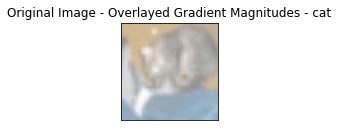

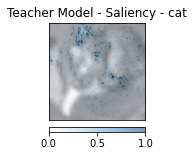

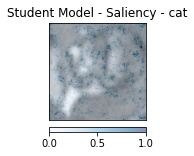

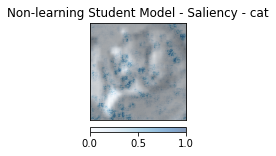

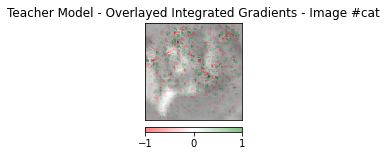

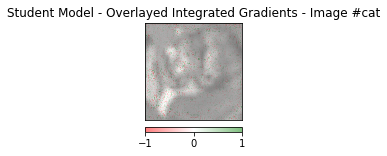

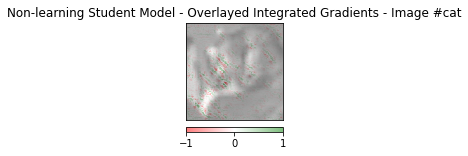

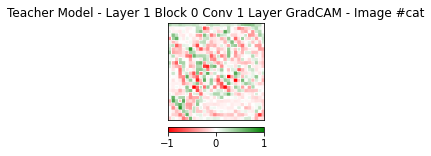

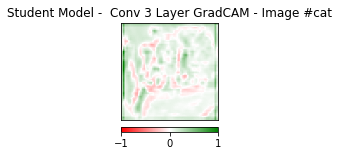

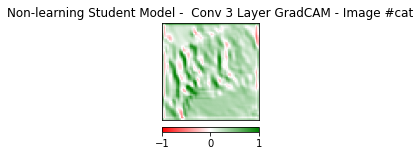

1


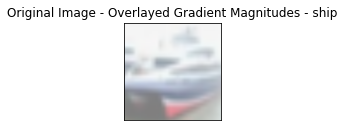

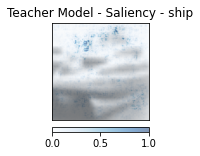

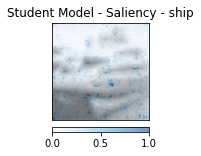

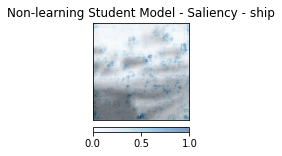

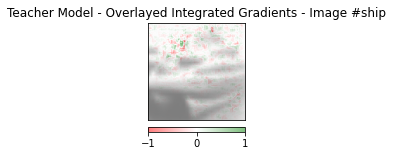

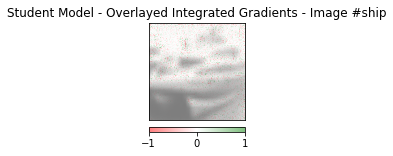

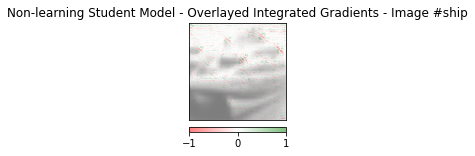

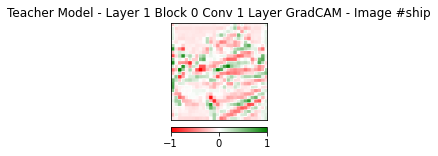

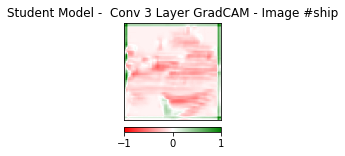

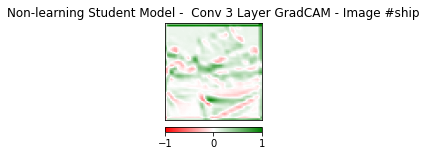

2


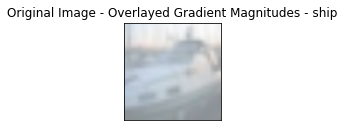

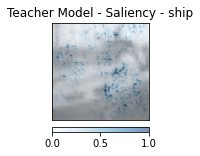

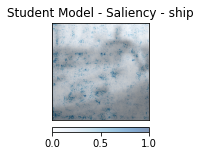

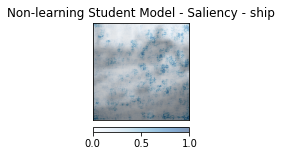

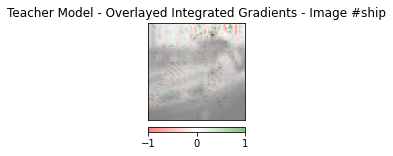

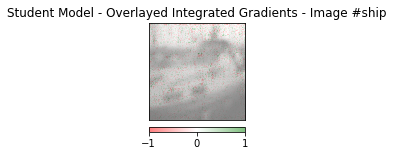

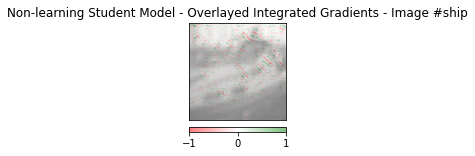

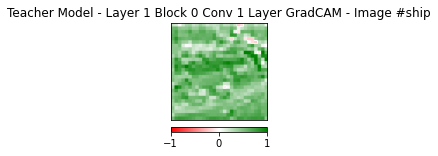

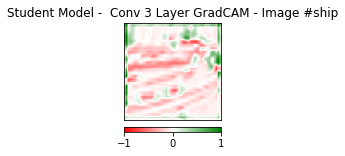

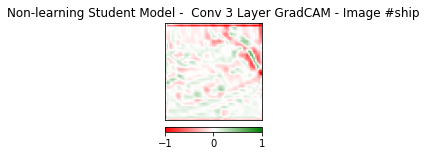

3


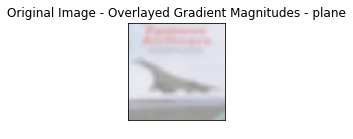

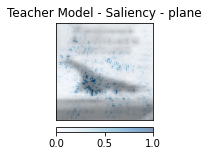

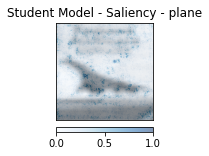

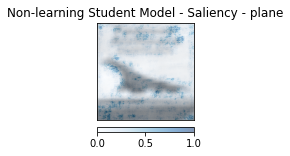

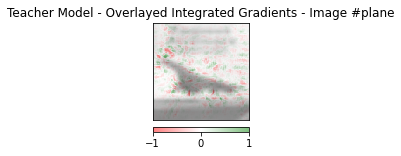

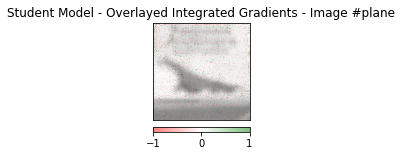

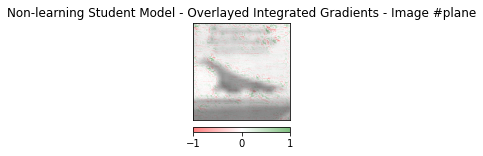

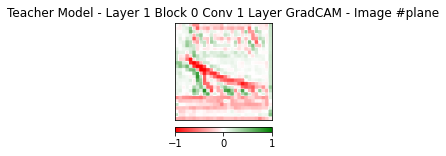

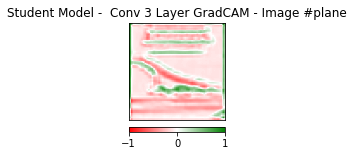

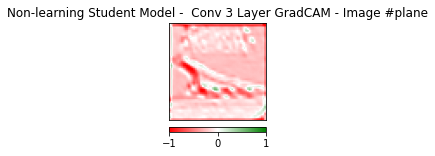

Weighted Average Distance Teacher: [76.75513838 81.49542577 78.60553678 73.55659226]
Weighted Average Distance Learning: [84.91040505 83.25257919 84.67370638 84.65317579]
Weighted Average Distance Non-Learning: [81.97481684 84.32311915 84.69801572 89.81195886]
here


In [18]:
img_index_list = np.arange(0,4)
avg_distance_teacher = np.empty((0,))
avg_distance_learning_student = np.empty((0,))
avg_distance_non_learning_student = np.empty((0,))
for img_index in img_index_list: 
    print(img_index)
    show_org_img(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Original Image', img_index=img_index)
    saliency_teacher = show_saliency_map(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Teacher Model', img_index=img_index)
    saliency_learning_student = show_saliency_map(model = learning_student, data_loader = test_loader_nonorm,title = 'Student Model', img_index=img_index)
    saliency_non_learning_student = show_saliency_map(model = non_learning_student, data_loader = test_loader_nonorm,title = 'Non-learning Student Model', img_index=img_index)
    show_integrated_grad(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Teacher Model', img_index=img_index)
    show_integrated_grad(model = learning_student, data_loader = test_loader_nonorm,title = 'Student Model', img_index=img_index)
    show_integrated_grad(model = non_learning_student, data_loader = test_loader_nonorm,title = 'Non-learning Student Model', img_index=img_index)
    
    model = teacher_resnet50
    conv_layer = model.layer2[0].conv2
    layer_gradCAM(model = model, conv_layer = conv_layer, data_loader = test_loader_nonorm, title = 'Teacher Model - Layer 1 Block 0 Conv 1', img_index=img_index)
    
    model = learning_student
    conv_layer = model.conv3
    layer_gradCAM(model = model, conv_layer = conv_layer, data_loader = test_loader_nonorm, title = 'Student Model -  Conv 3', img_index=img_index)
    
    model = non_learning_student
    conv_layer = model.conv3
    layer_gradCAM(model = model, conv_layer = conv_layer, data_loader = test_loader_nonorm, title = 'Non-learning Student Model -  Conv 3', img_index=img_index)
    
    saliency_teacher = saliency_teacher.mean(axis = (2))
    saliency_teacher_mean = weighted_average_distance(saliency_teacher)
    avg_distance_teacher = np.append(avg_distance_teacher,saliency_teacher_mean)
    
    saliency_learning_student = saliency_learning_student.mean(axis = (2))
    saliency_learning_student_mean = weighted_average_distance(saliency_learning_student)
    avg_distance_learning_student = np.append(avg_distance_learning_student,saliency_learning_student_mean) 
    
    saliency_non_learning_student = saliency_non_learning_student.mean(axis = (2))
    saliency_non_learning_student_mean = weighted_average_distance(saliency_non_learning_student)
    avg_distance_non_learning_student = np.append(avg_distance_non_learning_student,saliency_non_learning_student_mean) 

print("Weighted Average Distance Teacher:", avg_distance_teacher)
print("Weighted Average Distance Learning:", avg_distance_learning_student)
print("Weighted Average Distance Non-Learning:", avg_distance_non_learning_student)
print('here')

###Model resilience to disruption


In [11]:

noise_type = (transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
              transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
              transforms.AugMix(severity= 2,mixture_width=2, chain_depth  = - 1,
                                alpha  = 1.0, all_ops  = True,
                                interpolation = InterpolationMode.BILINEAR,
                                fill = None))

for noise in noise_type:
  print(noise)


  transform_noisy = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          noise,
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  test_dataset_noisy = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_noisy)
  test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=128, shuffle=False, num_workers=2)


  test_accuracy_teacher       = test(teacher_resnet50, test_loader_noisy, device)
  test_accuracy_non_learning  = test(non_learning_student, test_loader_noisy, device)
  test_accuracy_learning_student = test(learning_student, test_loader_noisy, device)

  # Compare the student test accuracy with and without the teacher, after distillation

  print(f"Teacher accuracy: {test_accuracy_teacher:.2f}%")
  print(f"Student accuracy without teacher: {test_accuracy_non_learning:.2f}%")
  print(f"Student accuracy with CE + KD: {test_accuracy_learning_student:.2f}%")


GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
Files already downloaded and verified
Test Accuracy: 95.69%
Test Accuracy: 66.07%
Test Accuracy: 83.64%
Teacher accuracy: 95.69%
Student accuracy without teacher: 66.07%
Student accuracy with CE + KD: 83.64%
ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
Files already downloaded and verified
Test Accuracy: 94.55%
Test Accuracy: 61.76%
Test Accuracy: 80.08%
Teacher accuracy: 94.55%
Student accuracy without teacher: 61.76%
Student accuracy with CE + KD: 80.08%
AugMix(severity=2, mixture_width=2, chain_depth=-1, alpha=1.0, all_ops=True, interpolation=InterpolationMode.BILINEAR, fill=None)
Files already downloaded and verified
Test Accuracy: 94.33%
Test Accuracy: 62.31%
Test Accuracy: 79.74%
Teacher accuracy: 94.33%
Student accuracy without teacher: 62.31%
Student accuracy with CE + KD: 79.74%


# Resnet and Intermediate Feature Transfer

Found a pretrained resnet32 on Cifar-10. 93% Accuracy reproduceable
https://github.com/chenyaofo/pytorch-cifar-models

In [ ]:
from helper import *

We set hooks to provide the activation outputs at the specified layers

In [ ]:
resnet32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet32", pretrained=True).to(device)
student_inter = studentNN(num_classes=10).to(device)

teacher_layer= resnet32.layer2[2]
teacher_activations = Hook(teacher_layer)

student_layer = student_inter.features[4]
student_activations = Hook(student_layer)

In [ ]:
test(resnet32, test_loader, device)
test(student_inter, test_loader, device)

In [ ]:
print(student_activations.output.shape)
print(teacher_activations.output.shape)
print(resnet32.layer2)
print(student_inter)

First stage training optimizes up to the hidden layer specified earlier, and uses the loss between teacher and student activations. Afterwards, we continue with the regular training routine

In [ ]:

train_first_stage(train_loader, student_inter, resnet32, hint_loss, 10, 0.001)
test(student_inter, test_loader, device)
train(student_inter, train_loader, epochs=10, learning_rate=0.001, device=device)
test(student_inter, test_loader, device)
